In [69]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import plotly
import plotly.graph_objs as go
import plotly.express as px

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import optimizers


# Model Architecture
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception

# System libraries
from pathlib import Path
import os.path

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model Hypertunning
!pip install -q keras_tuner
import keras_tuner as kt

# Preprocessing

In [3]:
train_path = '/kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/train'
test_path = '/kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/test'
valid_path = '/kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/val'

### Prepare Data Augmentation:

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    #width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    #height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    #shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Randomly zoom in by up to 20%
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

# data augmentation for validation
valid_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [5]:
images_size = 224
batch_size = 16

### Load the Images with a generator:

Why you should use flow_from_directory for Visualize Images ❓
📕 Using flow_from_directory in conjunction with ImageDataGenerator offers several advantages when working with image datasets in deep learning tasks. Here are some reasons why you might want to use flow_from_directory:

1. Directory Structure and Labels: If your data is organized in a directory structure where each subdirectory corresponds to a class, flow_from_directory can automatically assign labels to images based on the directory names. This eliminates the need for you to manually assign labels to each image.

2. Data Augmentation: ImageDataGenerator allows you to apply data augmentation techniques such as rotation, flipping, and scaling to your images on-the-fly while they are being loaded. This helps improve the generalization of your model and prevents overfitting.

3. Batch Loading: Loading images in batches helps manage memory efficiently, **especially when working with large datasets that may not fit into memory**. flow_from_directoryloads images in batches, allowing you to train your model with minimal memory usage.

4. Preprocessing: ImageDataGenerator` can apply preprocessing steps such as rescaling pixel values and standardizing input data on-the-fly. This ensures that your input data is properly preprocessed before being fed into the model.

5. Easy Integration with Keras Models The data generator returned by flow_from_directory can be directly used as input for Keras' fit and evaluate methods. This streamlines the training and evaluation process, making it easier to manage data loading and preprocessing.

6. Shuffling: By setting the shuffle parameter to True in flow_from_directory, you can shuffle the order of images within each epoch, preventing the model from memorizing the order of training examples.

7. Efficient Coding: Using flow_from_directory reduces the amount of manual coding required to load and preprocess images, freeing you to focus more on building and training your models.

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)


# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')


# Create a generator for validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 1977 images belonging to 10 classes.
Found 285 images belonging to 10 classes.
Found 564 images belonging to 10 classes.


# Data Distribution

📌 Class distribution plays a critical role in both the model training process and our overall understanding of the dataset. If the data is imbalanced, with some classes having significantly more samples than others, our model's results may be similarly imbalanced and biased towards the more heavily populated classes

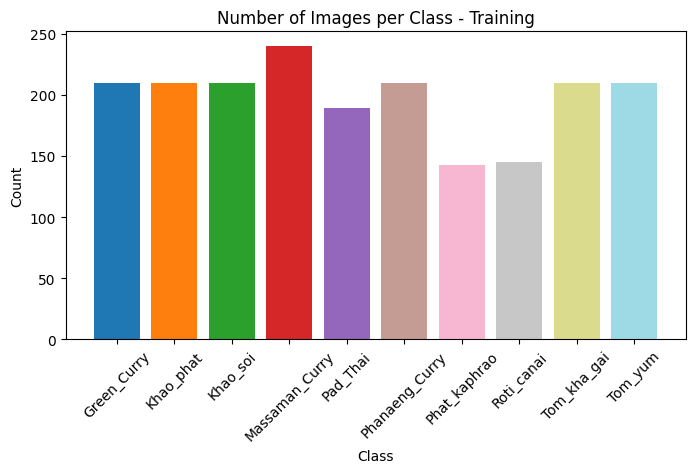

In [7]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class - Training')
plt.xticks(rotation=45)

# Add a legend for class colors
#legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
#plt.legend(handles=legend_labels, title="Classes")

plt.show()

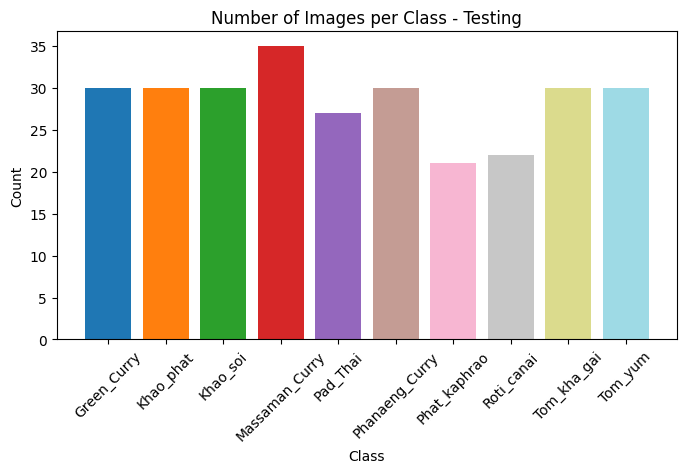

In [8]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class - Testing')
plt.xticks(rotation=45)

# Add a legend for class colors
#legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
#plt.legend(handles=legend_labels, title="Classes")

plt.show()

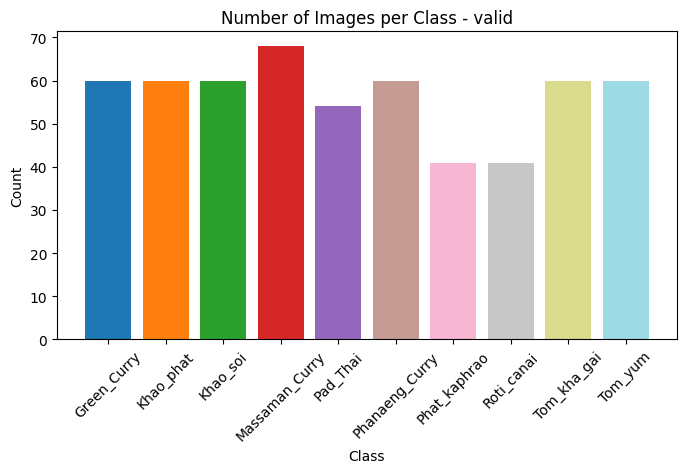

In [9]:
# Get the class labels
class_labels = list(valid_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(valid_generator)):
    batch_data, batch_labels = valid_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class - valid')
plt.xticks(rotation=45)

# Add a legend for class colors
#legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
#plt.legend(handles=legend_labels, title="Classes")

plt.show()

# Visualizing images

In [10]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),20))):
        plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

### Traning data

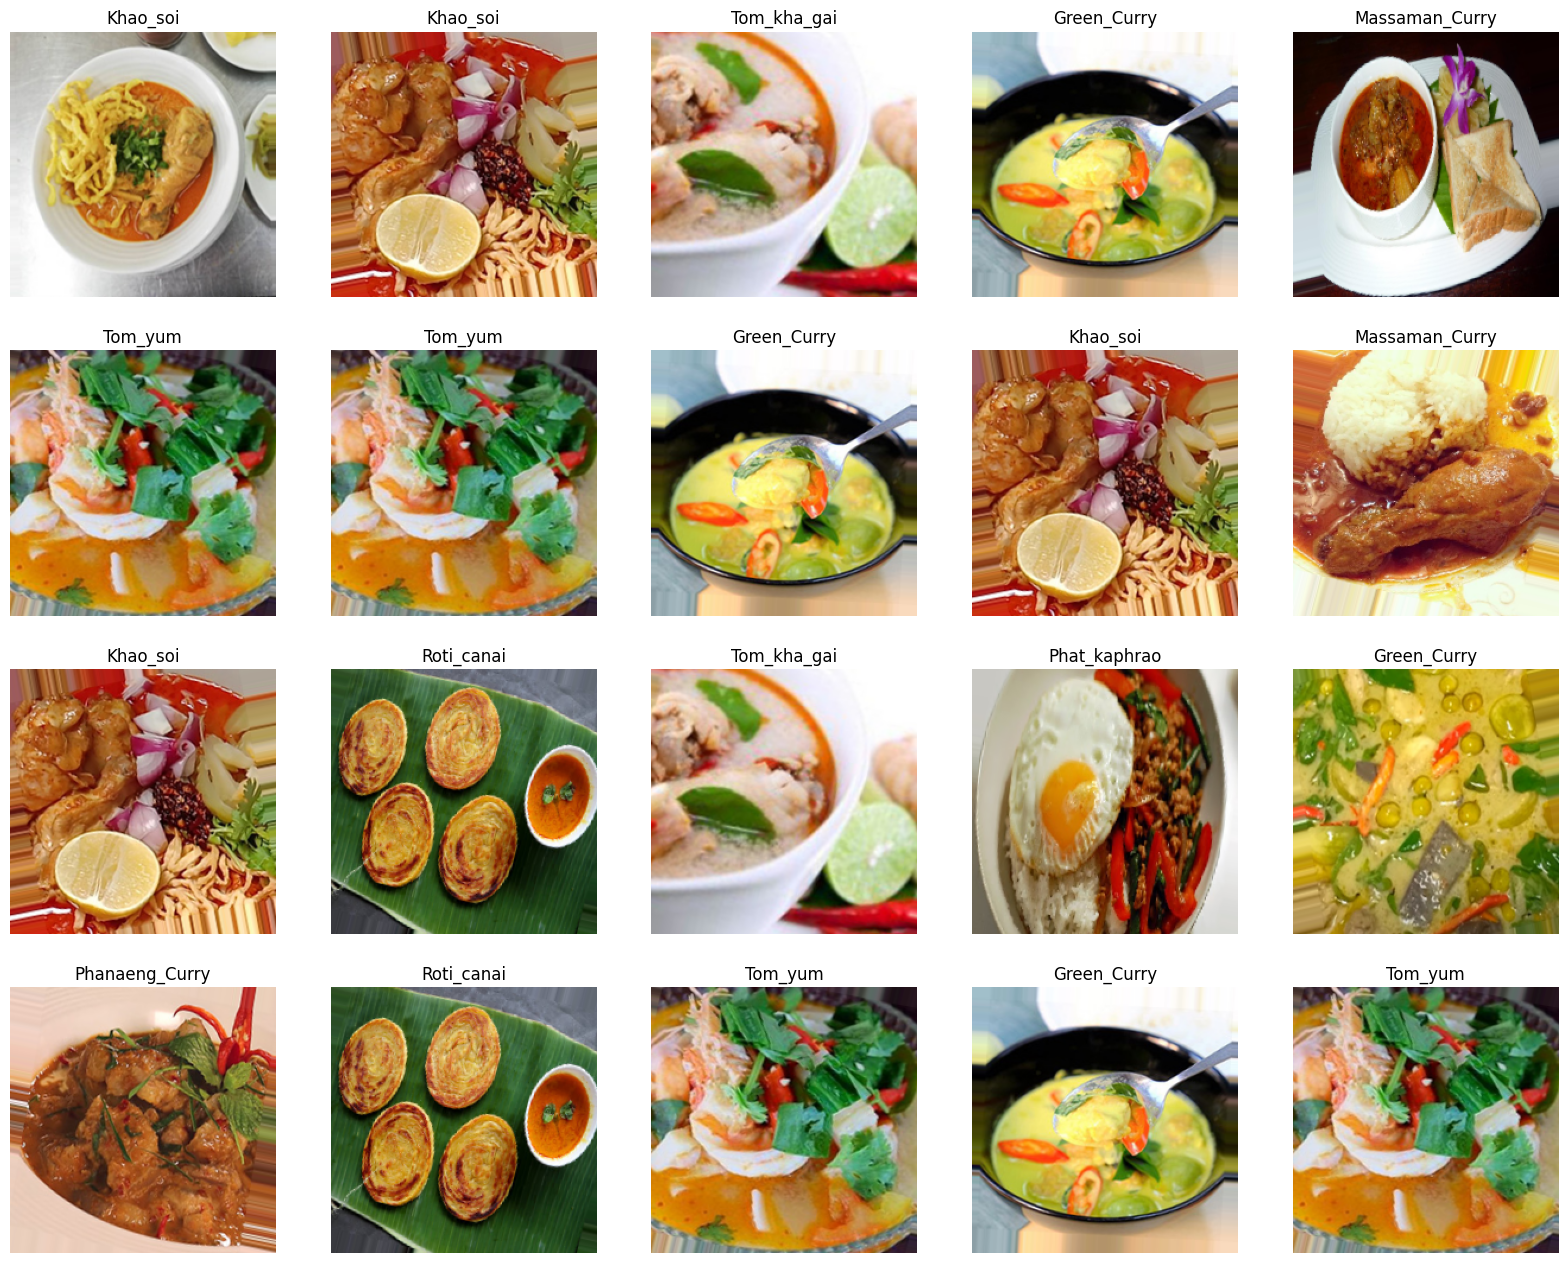

In [11]:
Show_Images(train_generator)

### Testing Data

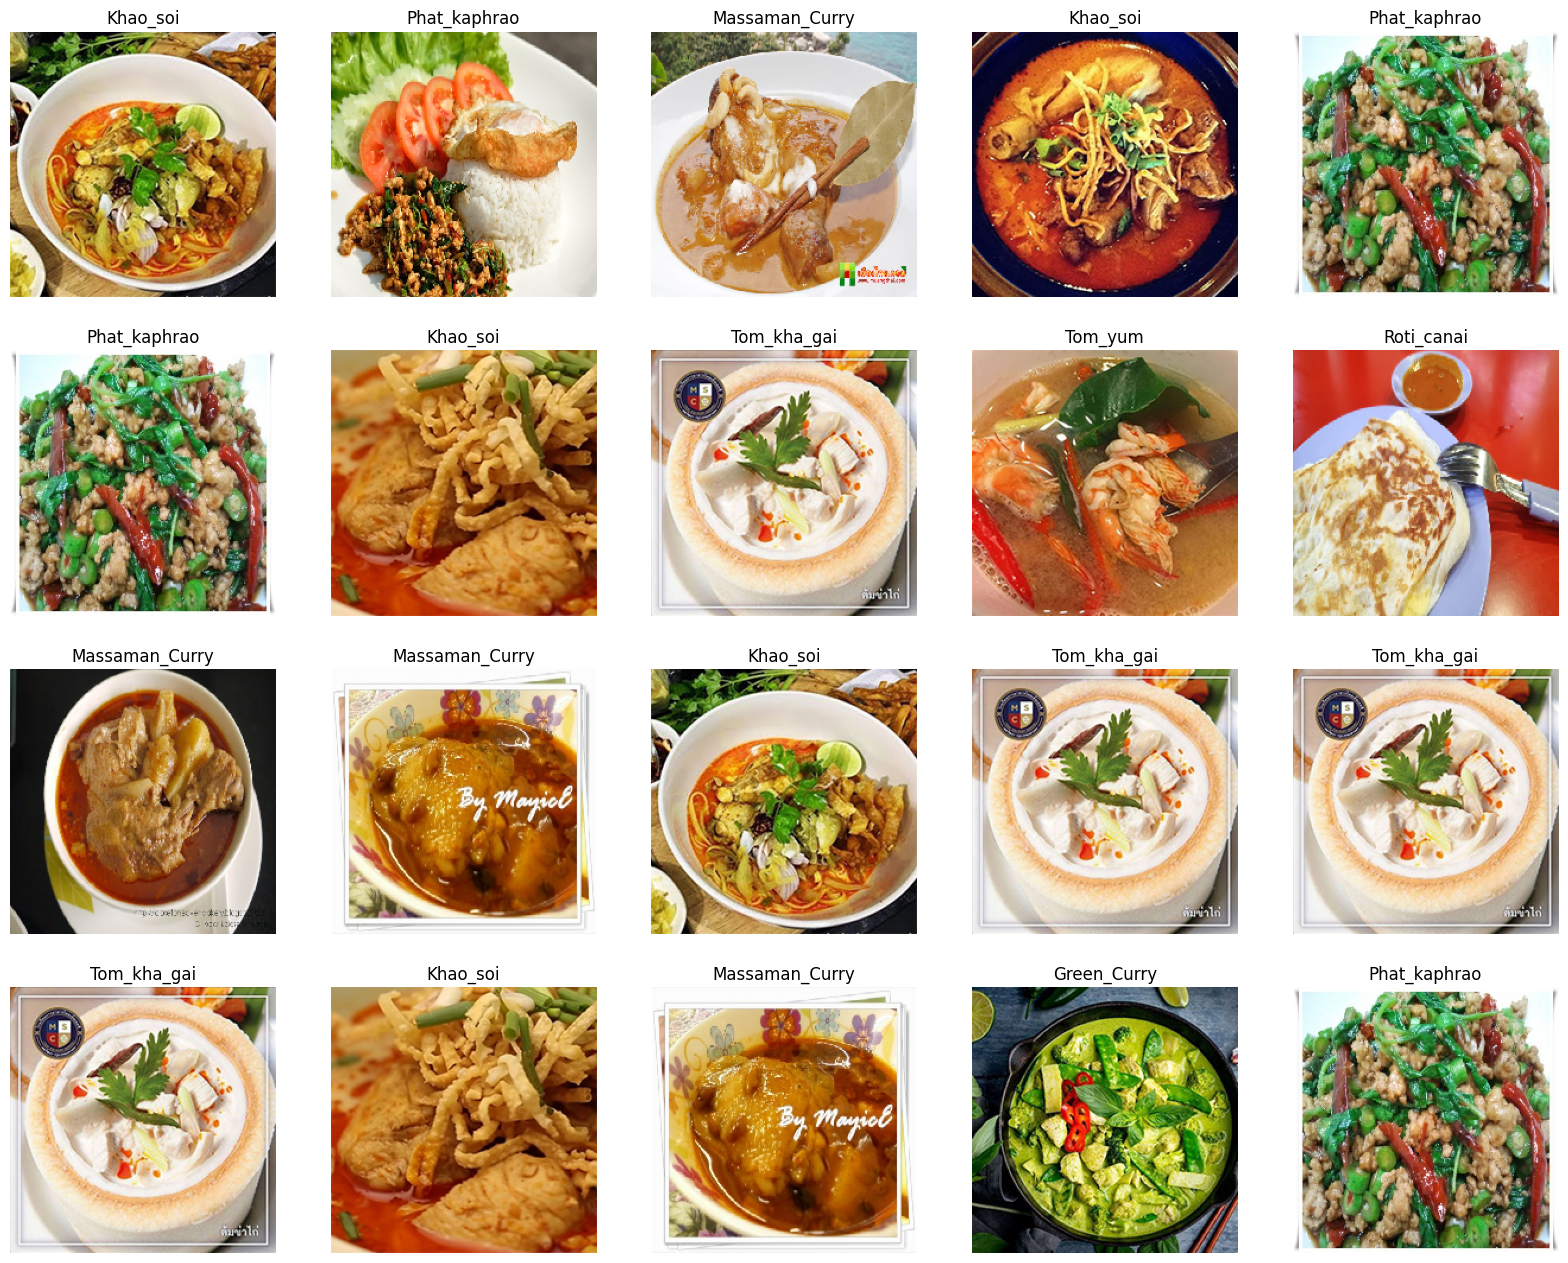

In [12]:
Show_Images(test_generator)

# Imbalanced Data Handling - 1) Re-Weighting

In [13]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.1428571428571428,
 1: 1.1428571428571428,
 2: 1.1428571428571428,
 3: 1.0,
 4: 1.2698412698412698,
 5: 1.1428571428571428,
 6: 1.6783216783216783,
 7: 1.6551724137931034,
 8: 1.1428571428571428,
 9: 1.1428571428571428}

# EarlyStopping

📕 Early stopping: works by monitoring the performance of the model on a validation set during training. The validation set is a set of data that is held out from the training data and is not used to train the model. The model's performance on the validation set is used to determine if the model is overfitting.
If the model's performance on the validation set starts to plateau or decrease, then the training is stopped early. This prevents the model from continuing to fit the training data too closely, which can lead to overfitting.

💡 Here is a simple analogy to help you understand early stopping:
Imagine you are trying to learn how to play a new game. You start by playing the game against a computer opponent. As you play, you get better and better at the game. However, at some point, you start to plateau. You are not getting any better at the game, even though you are still playing against the same computer opponent.

In [14]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Reduction learning_rate

Reduction of the learning rate means decreasing the step size (learning rate) during training to help a machine learning model converge more effectively and avoid convergence issues.

In [15]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=10,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

# Exponential Decay

📕 ExponentialDecay is a learning rate schedule that reduces the learning rate exponentially over time. This is done by multiplying the learning rate by a factor of less than 1, such as 0.5 or 0.9, after a certain number of epochs or training steps.

The formula for exponential decay can be expressed as:
New Value = Initial Value × Decay Rate ^(Step Count)
For example, if you start with an initial learning rate of 0.1 and use an exponential decay rate of 0.9, the learning rate might evolve as follows:
* After 1 step: (0.1 \times 0.9^1 = 0.09)
* After 2 steps: (0.1 \times 0.9^2 = 0.081)
* After 3 steps: (0.1 \times 0.9^3 = 0.0729)
* ...

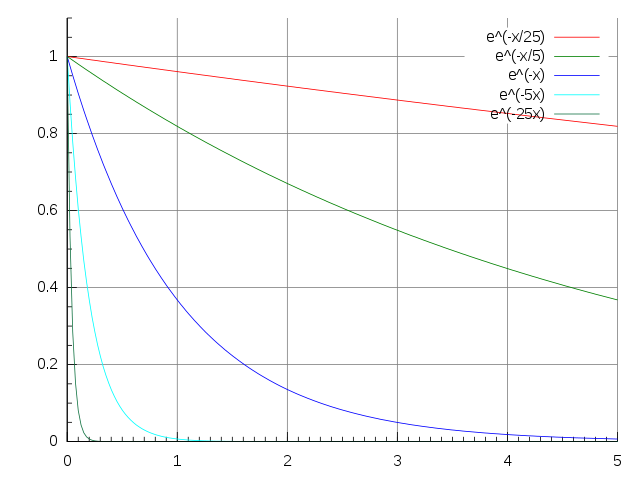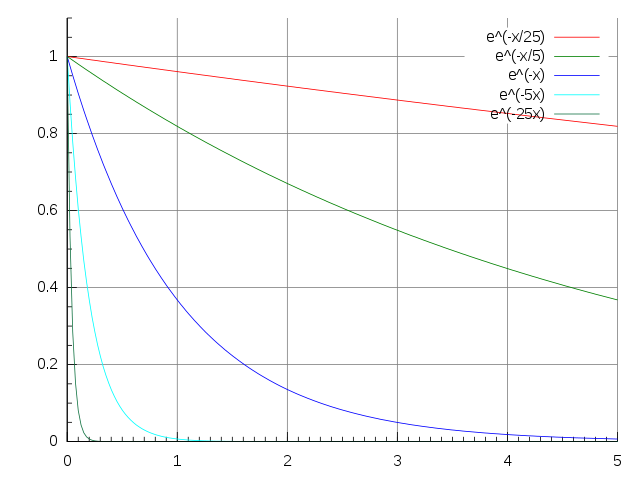

📘 ExponentialDecay is a common and effective learning rate schedule for image classification. It is often used in conjunction with other techniques, such as momentum and weight decay, to improve the performance of deep learning models.

✔️ Here are some of the benefits of using ExponentialDecay:
* It can help to prevent overfitting by reducing the learning rate over time.
* It can help the model to converge more quickly and smoothly.
* It can help to improve the fine-tuning performance of the model.

❌ However, there are also some potential drawbacks to usingExponentialDecay:
* It can be difficult to choose the right initial learning rate and decay rate.
* It can be slow to converge in the early stages of training.

💡 Overall, ExponentialDecay is a powerful learning rate schedule that can be used to improve the performance of deep learning models. However, it is important to carefully consider the benefits and drawbacks before using it.

In [16]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)


### Define Callbacks:

In [17]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

#  Compare between Models

🔴 In this section, we aim to compare different TL Models architectures to determine which one performs best on our dataset. we will first collect a small subset of the data and train a basic model architecture on it. then we will analyze the performance of these TL Models and choose the best one ✅.

In [55]:
# Collect all TL models
TL_Models =[
    #EfficientNetB3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    DenseNet201(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    #InceptionResNetV2(input_shape=(299, 299, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    NASNetMobile(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    VGG19(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    #Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    #'EfficientNetB3', ###
    'DenseNet201',
    #'InceptionResNetV2',
    'MobileNetV2',
    'NASNetMobile',
    'ResNet152V2',
    'VGG19',
    #'Xception'
    
]


# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

### Subset from training data

In [56]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [57]:
# Convert the one-hot encoded labels to a list of integers
y_sub_list = [tuple(label).index(1) for label in y_sub]

# Count the occurrences of each class in y_sub
counter = Counter(y_sub_list)

# Find the maximum count (max_val)
max_val = float(max(counter.values()))

# Calculate class weights for y_sub
class_weights_sub = {class_id: max_val / num_images for class_id, num_images in counter.items()}
class_weights_sub ##########

{6: 1.5,
 8: 1.125,
 4: 1.231578947368421,
 3: 1.0,
 2: 1.1142857142857143,
 0: 1.017391304347826,
 9: 1.231578947368421,
 1: 1.125,
 7: 1.4268292682926829,
 5: 1.1037735849056605}

### Training the Models and get Histories

In [58]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )
    
    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=20,
        validation_split=0.2,
        batch_size=batch_size,
        class_weight=class_weights_sub ##########
    )
        
    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
50/50 [==============================] - 21s 166ms/step - loss: 1.2820 - accuracy: 0.6525 - val_loss: 2.4799 - val_accuracy: 0.5920
Epoch 2/20
50/50 [==============================] - 5s 96ms/step - loss: 0.4885 - accuracy: 0.8400 - val_loss: 0.8146 - val_accuracy: 0.7811
Epoch 3/20
50/50 [==============================] - 5s 96ms/step - loss: 0.2658 - accuracy: 0.9137 - val_loss: 0.7912 - val_accuracy: 0.7861
Epoch 4/20
50/50 [==============================] - 5s 97ms/step - loss: 0.2008 - accuracy: 0.9388 - val_loss: 0.7199 - val_accuracy: 0.8010
Epoch 5/20
50/50 [==============================] - 5s 97ms/step - loss: 0.1589 - accuracy: 0.9513 - val_loss: 0.4129 - val_accuracy: 0.8905
Epoch 6/20
50/50 [==============================] - 5s 97ms/step - loss: 0.1207 - accuracy: 0.9700 - val_loss: 0.3561 - val_accuracy: 0.8657
Epoch 7/20
50/50 [==============================] - 5s 98ms/step - loss: 0.1065 - accuracy: 0.9700 - val_loss: 0.4258 - val_accuracy: 0.8756
Epoch 8/20


Training Tl Models:  20%|██        | 1/5 [01:55<07:43, 115.93s/it]

Epoch 1/20
50/50 [==============================] - 6s 58ms/step - loss: 1.4478 - accuracy: 0.5925 - val_loss: 1.4455 - val_accuracy: 0.7214
Epoch 2/20
50/50 [==============================] - 1s 27ms/step - loss: 0.6172 - accuracy: 0.8125 - val_loss: 0.8303 - val_accuracy: 0.8060
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 0.4707 - accuracy: 0.8612 - val_loss: 0.6150 - val_accuracy: 0.8010
Epoch 4/20
50/50 [==============================] - 1s 27ms/step - loss: 0.3501 - accuracy: 0.8938 - val_loss: 0.8182 - val_accuracy: 0.7811
Epoch 5/20
50/50 [==============================] - 1s 27ms/step - loss: 0.2441 - accuracy: 0.9287 - val_loss: 0.7141 - val_accuracy: 0.8060
Epoch 6/20
50/50 [==============================] - 1s 27ms/step - loss: 0.1988 - accuracy: 0.9337 - val_loss: 0.7383 - val_accuracy: 0.7811
Epoch 7/20
50/50 [==============================] - 1s 27ms/step - loss: 0.1747 - accuracy: 0.9500 - val_loss: 0.7664 - val_accuracy: 0.8060
Epoch 8/20
50

Training Tl Models:  40%|████      | 2/5 [02:29<03:22, 67.44s/it] 

Epoch 1/20
50/50 [==============================] - 21s 142ms/step - loss: 1.8881 - accuracy: 0.5025 - val_loss: 4.0258 - val_accuracy: 0.2935
Epoch 2/20
50/50 [==============================] - 2s 46ms/step - loss: 1.0386 - accuracy: 0.6963 - val_loss: 1.8553 - val_accuracy: 0.5274
Epoch 3/20
50/50 [==============================] - 2s 46ms/step - loss: 0.8100 - accuracy: 0.7500 - val_loss: 1.0908 - val_accuracy: 0.6716
Epoch 4/20
50/50 [==============================] - 2s 46ms/step - loss: 0.7398 - accuracy: 0.7825 - val_loss: 1.1656 - val_accuracy: 0.7015
Epoch 5/20
50/50 [==============================] - 2s 47ms/step - loss: 0.5247 - accuracy: 0.8438 - val_loss: 0.8323 - val_accuracy: 0.7313
Epoch 6/20
50/50 [==============================] - 2s 46ms/step - loss: 0.4518 - accuracy: 0.8537 - val_loss: 0.7627 - val_accuracy: 0.7512
Epoch 7/20
50/50 [==============================] - 2s 47ms/step - loss: 0.3863 - accuracy: 0.8925 - val_loss: 0.8433 - val_accuracy: 0.7264
Epoch 8/20


Training Tl Models:  60%|██████    | 3/5 [03:37<02:15, 67.77s/it]

Epoch 1/20
50/50 [==============================] - 20s 222ms/step - loss: 1.6034 - accuracy: 0.5612 - val_loss: 1.7777 - val_accuracy: 0.6617
Epoch 2/20
50/50 [==============================] - 7s 149ms/step - loss: 0.7378 - accuracy: 0.7812 - val_loss: 0.6843 - val_accuracy: 0.7910
Epoch 3/20
50/50 [==============================] - 8s 151ms/step - loss: 0.4616 - accuracy: 0.8550 - val_loss: 0.7241 - val_accuracy: 0.8010
Epoch 4/20
50/50 [==============================] - 8s 152ms/step - loss: 0.3801 - accuracy: 0.8775 - val_loss: 0.6509 - val_accuracy: 0.7811
Epoch 5/20
50/50 [==============================] - 8s 154ms/step - loss: 0.3901 - accuracy: 0.8913 - val_loss: 0.7500 - val_accuracy: 0.7811
Epoch 6/20
50/50 [==============================] - 8s 153ms/step - loss: 0.2909 - accuracy: 0.9075 - val_loss: 0.8655 - val_accuracy: 0.7811
Epoch 7/20
50/50 [==============================] - 8s 152ms/step - loss: 0.1890 - accuracy: 0.9475 - val_loss: 0.7467 - val_accuracy: 0.8010
Epoch

Training Tl Models:  80%|████████  | 4/5 [06:22<01:46, 106.29s/it]

Epoch 1/20
50/50 [==============================] - 10s 142ms/step - loss: 2.1855 - accuracy: 0.3975 - val_loss: 2.3128 - val_accuracy: 0.2587
Epoch 2/20
50/50 [==============================] - 5s 100ms/step - loss: 1.3979 - accuracy: 0.5888 - val_loss: 1.7030 - val_accuracy: 0.4478
Epoch 3/20
50/50 [==============================] - 5s 100ms/step - loss: 1.2128 - accuracy: 0.6275 - val_loss: 1.4805 - val_accuracy: 0.5025
Epoch 4/20
50/50 [==============================] - 5s 102ms/step - loss: 1.0645 - accuracy: 0.6950 - val_loss: 1.1652 - val_accuracy: 0.5920
Epoch 5/20
50/50 [==============================] - 5s 102ms/step - loss: 0.9231 - accuracy: 0.7088 - val_loss: 1.4839 - val_accuracy: 0.5373
Epoch 6/20
50/50 [==============================] - 5s 102ms/step - loss: 0.8357 - accuracy: 0.7513 - val_loss: 1.2541 - val_accuracy: 0.6020
Epoch 7/20
50/50 [==============================] - 5s 101ms/step - loss: 0.7029 - accuracy: 0.7875 - val_loss: 1.1453 - val_accuracy: 0.6368
Epoch

Training Tl Models: 100%|██████████| 5/5 [08:48<00:00, 105.64s/it]


### Analyze the performance of TL Models


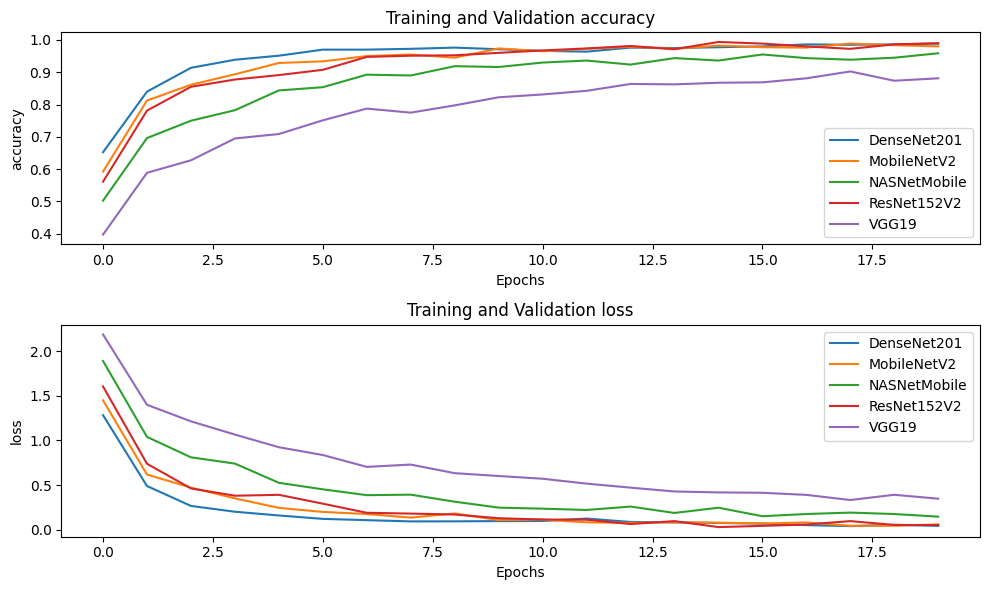

In [59]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [65]:
import plotly.graph_objs as go

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create separate figures for each metric
for metric in metrics_to_plot:
    fig = go.Figure()

    for idx, history in enumerate(HISTORIES):
        fig.add_trace(go.Scatter(x=list(range(1, len(history[metric]) + 1)), y=history[metric], mode='lines', name=TL_Models_NAMES[idx]))

    fig.update_layout(
        title=f'Training and Validation {metric}',
        xaxis_title='Epochs',
        yaxis_title=metric
    )
    
    fig.show()


In [61]:
# Create a bar chart for the last accuracy and loss
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Last Accuracy', 'Last Loss'])

# Get the last accuracy and loss values for each model
last_accuracy = [history['accuracy'][-1] for history in HISTORIES]
last_loss = [history['loss'][-1] for history in HISTORIES]

# Create bar charts
accuracy_trace = go.Bar(x=TL_Models_NAMES, y=last_accuracy, name='Accuracy')
loss_trace = go.Bar(x=TL_Models_NAMES, y=last_loss, name='Loss')

# Add the bar charts to the subplots
fig.append_trace(accuracy_trace, row=1, col=1)
fig.append_trace(loss_trace, row=1, col=2)

# Update the layout
fig.update_xaxes(title_text='Model', row=1, col=1)
fig.update_xaxes(title_text='Model', row=1, col=2)
fig.update_yaxes(title_text='Accuracy', row=1, col=1)
fig.update_yaxes(title_text='Loss', row=1, col=2)

fig.update_layout(height=400, width=800, showlegend=False)

fig.show()

In [66]:
# Get the last accuracy and loss values for each model
last_accuracy_values = [history['accuracy'][-1] for history in HISTORIES]
last_loss_values = [history['loss'][-1] for history in HISTORIES]

# Print the last accuracy and loss values for each model
for model, last_accuracy, last_loss in zip(TL_Models_NAMES, last_accuracy_values, last_loss_values):
    print(f'Model: {model}, Last Accuracy: {last_accuracy}, Last Loss: {last_loss}')


Model: DenseNet201, Last Accuracy: 0.9887499809265137, Last Loss: 0.04262871667742729
Model: MobileNetV2, Last Accuracy: 0.9800000190734863, Last Loss: 0.05892036855220795
Model: NASNetMobile, Last Accuracy: 0.9587500095367432, Last Loss: 0.14556464552879333
Model: ResNet152V2, Last Accuracy: 0.9900000095367432, Last Loss: 0.05159531906247139
Model: VGG19, Last Accuracy: 0.8812500238418579, Last Loss: 0.34657496213912964


# Model

### 1) DenseNet201

 Get the weights

In [71]:
##### Get the weights #####
base_model_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3)) ### !!!

##### Freeze the layers of the base model #####
for layer in base_model_DenseNet201.layers: ### !!!
    layer.trainable = False
    
##### Build the model #####
model_DenseNet201 = tf.keras.models.Sequential([
    base_model_DenseNet201, ### !!!
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_DenseNet201.summary()

##### Set the optimizer #####
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model_DenseNet201.compile(optimizer=optimizer, ##### !!!
                          loss="categorical_crossentropy",
                          metrics=['accuracy'])



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_16  (None, 1920)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_32 (Dense)            (None, 256)               491776    
                                                                 
 batch_normalization_223 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 10)              

In [72]:
##### Training model #####

history = model_DenseNet201.fit( ### !!!
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[callback]
)

Epoch 1/100
123/123 [==============================] - 47s 280ms/step - loss: 1.0011 - accuracy: 0.7221 - val_loss: 0.4830 - val_accuracy: 0.8375 - lr: 0.0092
Epoch 2/100
123/123 [==============================] - 30s 246ms/step - loss: 0.5248 - accuracy: 0.8516 - val_loss: 0.3191 - val_accuracy: 0.8857 - lr: 0.0084
Epoch 3/100
123/123 [==============================] - 30s 246ms/step - loss: 0.4450 - accuracy: 0.8633 - val_loss: 0.3691 - val_accuracy: 0.8875 - lr: 0.0077
Epoch 4/100
123/123 [==============================] - 31s 251ms/step - loss: 0.3324 - accuracy: 0.9102 - val_loss: 0.3124 - val_accuracy: 0.9107 - lr: 0.0071
Epoch 5/100
123/123 [==============================] - 30s 243ms/step - loss: 0.3338 - accuracy: 0.9046 - val_loss: 0.2939 - val_accuracy: 0.9036 - lr: 0.0065
Epoch 6/100
123/123 [==============================] - 30s 245ms/step - loss: 0.3141 - accuracy: 0.9072 - val_loss: 0.2413 - val_accuracy: 0.9214 - lr: 0.0060
Epoch 7/100
123/123 [=========================

In [73]:
##### Plot ACC #####

h1_ACC = go.Scatter(y=history.history['accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="acc"
                   )
h2_ACC = go.Scatter(y=history.history['val_accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_acc"
                   )

data_ACC = [h1_ACC ,h2_ACC]
layout_ACC = go.Layout(title='Accuracy',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_ACC = go.Figure(data = data_ACC, layout=layout_ACC)
plotly.offline.iplot(fig_ACC)


##### Plot Loss #####

h1_Loss = go.Scatter(y=history.history['loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="loss"
                   )
h2_Loss = go.Scatter(y=history.history['val_loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_loss"
                   )

data_Loss = [h1_Loss,h2_Loss]
layout_Loss = go.Layout(title='Loss',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_Loss = go.Figure(data = data_Loss, layout=layout_Loss)
plotly.offline.iplot(fig_Loss)


Test loss: 0.15090389549732208
Test accuracy: 0.9508771896362305
1/1 [==============================] - 0s 44ms/step


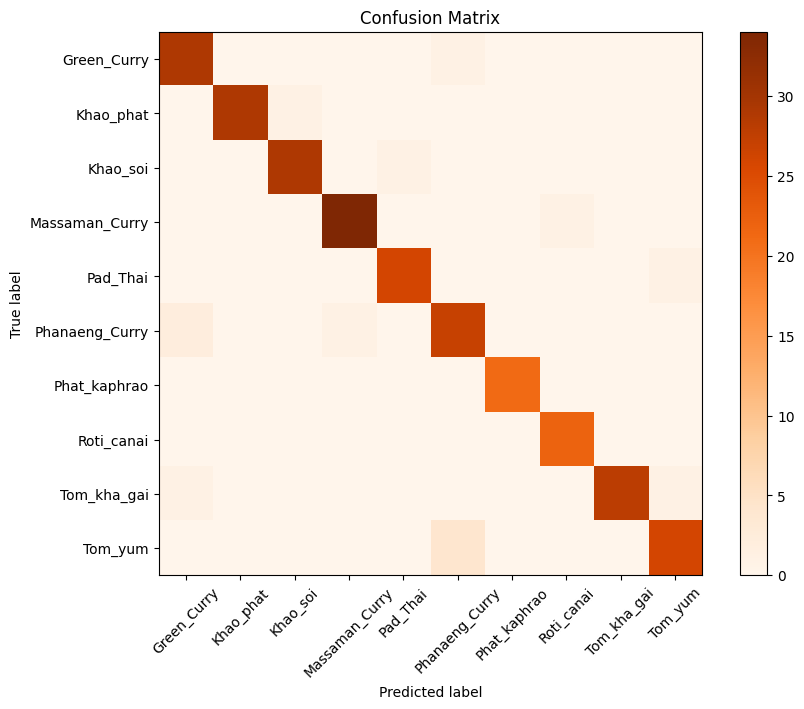

In [74]:
##### Evaluate the testing #####
score = model_DenseNet201.evaluate(test_generator, verbose=False) ### !!!
print('Test loss:', score[0])
print('Test accuracy:', score[1])

true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model_DenseNet201.predict(x_batch) ### !!!
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [75]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

                precision    recall  f1-score   support

   Green_Curry       0.91      0.97      0.94        30
     Khao_phat       1.00      0.97      0.98        30
      Khao_soi       0.97      0.97      0.97        30
Massaman_Curry       0.97      0.97      0.97        35
      Pad_Thai       0.96      0.96      0.96        27
Phanaeng_Curry       0.84      0.90      0.87        30
  Phat_kaphrao       1.00      1.00      1.00        21
    Roti_canai       0.96      1.00      0.98        22
   Tom_kha_gai       1.00      0.93      0.97        30
       Tom_yum       0.93      0.87      0.90        30

      accuracy                           0.95       285
     macro avg       0.95      0.95      0.95       285
  weighted avg       0.95      0.95      0.95       285



In [114]:
model_DenseNet201.save('model_DenseNet201_RUN_1.keras')

### 2) MobileNetV2

In [116]:
##### Get the weights #####
base_model_MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3)) ### !!!

##### Freeze the layers of the base model #####
for layer in base_model_MobileNetV2.layers: ### !!!
    layer.trainable = False
    
##### Build the model #####
model_MobileNetV2 = tf.keras.models.Sequential([ ### !!!
    base_model_MobileNetV2, ### !!!
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_MobileNetV2.summary()

##### Set the optimizer #####
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model_MobileNetV2.compile(optimizer=optimizer, ##### !!!
                          loss="categorical_crossentropy",
                          metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_18  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_36 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_225 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                     

In [117]:
##### Training model #####

history = model_MobileNetV2.fit( ### !!!
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[callback]
)

Epoch 1/100
123/123 [==============================] - 35s 246ms/step - loss: 1.1914 - accuracy: 0.6752 - val_loss: 0.4649 - val_accuracy: 0.8411 - lr: 0.0092
Epoch 2/100
123/123 [==============================] - 28s 226ms/step - loss: 0.7063 - accuracy: 0.8016 - val_loss: 0.5753 - val_accuracy: 0.8196 - lr: 0.0084
Epoch 3/100
123/123 [==============================] - 28s 225ms/step - loss: 0.5721 - accuracy: 0.8327 - val_loss: 0.3908 - val_accuracy: 0.8571 - lr: 0.0077
Epoch 4/100
123/123 [==============================] - 27s 223ms/step - loss: 0.4773 - accuracy: 0.8587 - val_loss: 0.3538 - val_accuracy: 0.8696 - lr: 0.0071
Epoch 5/100
123/123 [==============================] - 27s 222ms/step - loss: 0.4570 - accuracy: 0.8720 - val_loss: 0.3237 - val_accuracy: 0.8929 - lr: 0.0065
Epoch 6/100
123/123 [==============================] - 27s 221ms/step - loss: 0.4080 - accuracy: 0.8802 - val_loss: 0.5451 - val_accuracy: 0.8339 - lr: 0.0060
Epoch 7/100
123/123 [=========================

In [118]:
##### Plot ACC #####

h1_ACC = go.Scatter(y=history.history['accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="acc"
                   )
h2_ACC = go.Scatter(y=history.history['val_accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_acc"
                   )

data_ACC = [h1_ACC ,h2_ACC]
layout_ACC = go.Layout(title='Accuracy',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_ACC = go.Figure(data = data_ACC, layout=layout_ACC)
plotly.offline.iplot(fig_ACC)


##### Plot Loss #####

h1_Loss = go.Scatter(y=history.history['loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="loss"
                   )
h2_Loss = go.Scatter(y=history.history['val_loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_loss"
                   )

data_Loss = [h1_Loss,h2_Loss]
layout_Loss = go.Layout(title='Loss',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_Loss = go.Figure(data = data_Loss, layout=layout_Loss)
plotly.offline.iplot(fig_Loss)

Test loss: 0.3182277977466583
Test accuracy: 0.898245632648468
1/1 [==============================] - 0s 27ms/step


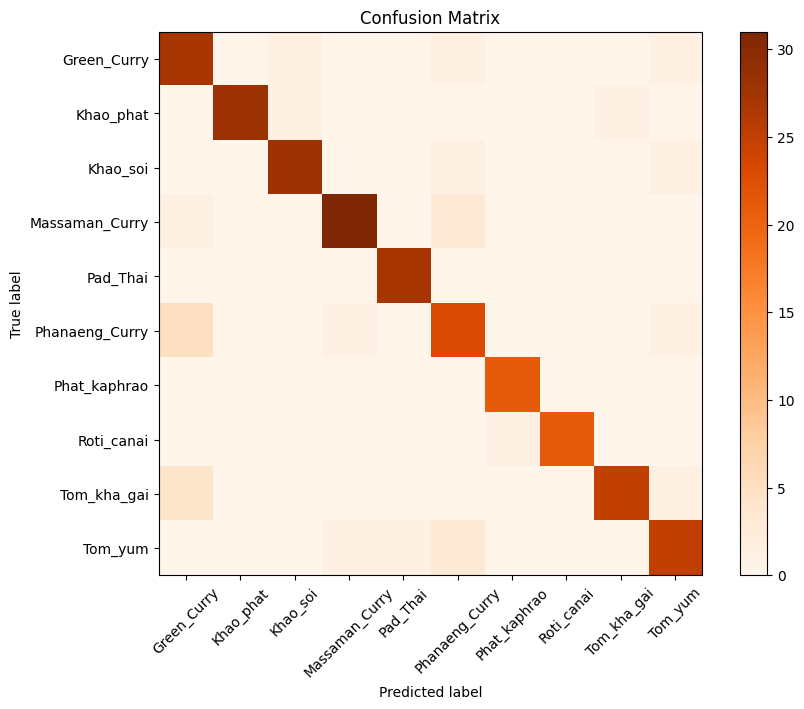

In [123]:
##### Evaluate the testing #####
score = model_MobileNetV2.evaluate(test_generator, verbose=False) ### !!!
print('Test loss:', score[0])
print('Test accuracy:', score[1])

true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model_MobileNetV2.predict(x_batch) ### !!!
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [124]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

                precision    recall  f1-score   support

   Green_Curry       0.73      0.90      0.81        30
     Khao_phat       1.00      0.93      0.97        30
      Khao_soi       0.93      0.93      0.93        30
Massaman_Curry       0.94      0.89      0.91        35
      Pad_Thai       0.96      1.00      0.98        27
Phanaeng_Curry       0.74      0.77      0.75        30
  Phat_kaphrao       0.95      1.00      0.98        21
    Roti_canai       1.00      0.95      0.98        22
   Tom_kha_gai       0.96      0.83      0.89        30
       Tom_yum       0.86      0.83      0.85        30

      accuracy                           0.90       285
     macro avg       0.91      0.90      0.90       285
  weighted avg       0.90      0.90      0.90       285



In [126]:
model_MobileNetV2.save('02_model_MobileNetV2_RUN_1.keras')

### 3) NASNetMobile

In [127]:
##### Get the weights #####
base_model_NASNetMobile = NASNetMobile(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3)) ### !!!

##### Freeze the layers of the base model #####
for layer in base_model_NASNetMobile.layers: ### !!!
    layer.trainable = False
    
##### Build the model #####
model_NASNetMobile = tf.keras.models.Sequential([
    base_model_NASNetMobile, ### !!!
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_NASNetMobile.summary()

##### Set the optimizer #####
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model_NASNetMobile.compile(optimizer=optimizer, ##### !!!
                          loss="categorical_crossentropy",
                          metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_19  (None, 1056)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_38 (Dense)            (None, 256)               270592    
                                                                 
 batch_normalization_226 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 10)              

In [129]:
##### Training model #####

history = model_NASNetMobile.fit( ### !!!
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[callback]
)

Epoch 1/100
123/123 [==============================] - 50s 295ms/step - loss: 1.5287 - accuracy: 0.5987 - val_loss: 1.3915 - val_accuracy: 0.5804 - lr: 0.0092
Epoch 2/100
123/123 [==============================] - 29s 232ms/step - loss: 1.0471 - accuracy: 0.6900 - val_loss: 0.7216 - val_accuracy: 0.7571 - lr: 0.0084
Epoch 3/100
123/123 [==============================] - 29s 235ms/step - loss: 0.9310 - accuracy: 0.7302 - val_loss: 0.6637 - val_accuracy: 0.7875 - lr: 0.0077
Epoch 4/100
123/123 [==============================] - 29s 233ms/step - loss: 0.8023 - accuracy: 0.7680 - val_loss: 0.6230 - val_accuracy: 0.7946 - lr: 0.0071
Epoch 5/100
123/123 [==============================] - 28s 230ms/step - loss: 0.7487 - accuracy: 0.7863 - val_loss: 0.6237 - val_accuracy: 0.7911 - lr: 0.0065
Epoch 6/100
123/123 [==============================] - 28s 232ms/step - loss: 0.6752 - accuracy: 0.7991 - val_loss: 0.5371 - val_accuracy: 0.8018 - lr: 0.0060
Epoch 7/100
123/123 [=========================

In [130]:
##### Plot ACC #####

h1_ACC = go.Scatter(y=history.history['accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="acc"
                   )
h2_ACC = go.Scatter(y=history.history['val_accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_acc"
                   )

data_ACC = [h1_ACC ,h2_ACC]
layout_ACC = go.Layout(title='Accuracy',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_ACC = go.Figure(data = data_ACC, layout=layout_ACC)
plotly.offline.iplot(fig_ACC)


##### Plot Loss #####

h1_Loss = go.Scatter(y=history.history['loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="loss"
                   )
h2_Loss = go.Scatter(y=history.history['val_loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_loss"
                   )

data_Loss = [h1_Loss,h2_Loss]
layout_Loss = go.Layout(title='Loss',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_Loss = go.Figure(data = data_Loss, layout=layout_Loss)
plotly.offline.iplot(fig_Loss)

Test loss: 0.5254884362220764
Test accuracy: 0.8350877165794373
1/1 [==============================] - 0s 41ms/step


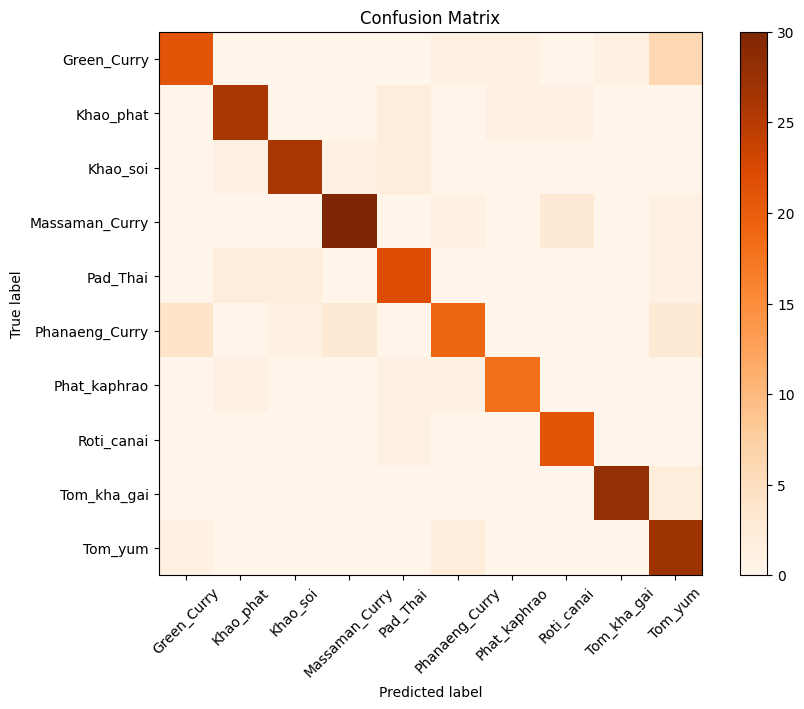

In [131]:
##### Evaluate the testing #####
score = model_NASNetMobile.evaluate(test_generator, verbose=False) ### !!!
print('Test loss:', score[0])
print('Test accuracy:', score[1])

true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model_NASNetMobile.predict(x_batch) ### !!!
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [132]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

                precision    recall  f1-score   support

   Green_Curry       0.81      0.70      0.75        30
     Khao_phat       0.87      0.87      0.87        30
      Khao_soi       0.90      0.87      0.88        30
Massaman_Curry       0.88      0.86      0.87        35
      Pad_Thai       0.79      0.81      0.80        27
Phanaeng_Curry       0.79      0.63      0.70        30
  Phat_kaphrao       0.90      0.86      0.88        21
    Roti_canai       0.84      0.95      0.89        22
   Tom_kha_gai       0.97      0.93      0.95        30
       Tom_yum       0.68      0.90      0.77        30

      accuracy                           0.84       285
     macro avg       0.84      0.84      0.84       285
  weighted avg       0.84      0.84      0.83       285



In [134]:
model_NASNetMobile.save('03_model_NASNetMobile_RUN_1.keras')

### 4) ResNet152V2

In [135]:
##### Get the weights #####
base_model_ResNet152V2 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3)) ### !!!

##### Freeze the layers of the base model #####
for layer in base_model_ResNet152V2.layers: ### !!!
    layer.trainable = False
    
##### Build the model #####
model_ResNet152V2 = tf.keras.models.Sequential([
    base_model_ResNet152V2, ### !!!
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_ResNet152V2.summary()

##### Set the optimizer #####
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model_ResNet152V2.compile(optimizer=optimizer, ##### !!!
                          loss="categorical_crossentropy",
                          metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_20  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_40 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_227 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 10)              

In [136]:
##### Training model #####

history = model_ResNet152V2.fit( ### !!!
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[callback]
)

Epoch 1/100
123/123 [==============================] - 44s 279ms/step - loss: 1.4212 - accuracy: 0.6155 - val_loss: 1.1143 - val_accuracy: 0.7304 - lr: 0.0092
Epoch 2/100
123/123 [==============================] - 32s 257ms/step - loss: 0.8950 - accuracy: 0.7466 - val_loss: 0.6473 - val_accuracy: 0.8054 - lr: 0.0084
Epoch 3/100
123/123 [==============================] - 32s 257ms/step - loss: 0.7196 - accuracy: 0.8001 - val_loss: 0.5298 - val_accuracy: 0.8339 - lr: 0.0077
Epoch 4/100
123/123 [==============================] - 31s 254ms/step - loss: 0.5791 - accuracy: 0.8297 - val_loss: 0.4666 - val_accuracy: 0.8518 - lr: 0.0071
Epoch 5/100
123/123 [==============================] - 31s 252ms/step - loss: 0.5935 - accuracy: 0.8332 - val_loss: 0.5445 - val_accuracy: 0.8268 - lr: 0.0065
Epoch 6/100
123/123 [==============================] - 31s 253ms/step - loss: 0.5050 - accuracy: 0.8547 - val_loss: 1.0097 - val_accuracy: 0.8304 - lr: 0.0060
Epoch 7/100
123/123 [=========================

In [137]:
##### Plot ACC #####

h1_ACC = go.Scatter(y=history.history['accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="acc"
                   )
h2_ACC = go.Scatter(y=history.history['val_accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_acc"
                   )

data_ACC = [h1_ACC ,h2_ACC]
layout_ACC = go.Layout(title='Accuracy',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_ACC = go.Figure(data = data_ACC, layout=layout_ACC)
plotly.offline.iplot(fig_ACC)


##### Plot Loss #####

h1_Loss = go.Scatter(y=history.history['loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="loss"
                   )
h2_Loss = go.Scatter(y=history.history['val_loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_loss"
                   )

data_Loss = [h1_Loss,h2_Loss]
layout_Loss = go.Layout(title='Loss',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_Loss = go.Figure(data = data_Loss, layout=layout_Loss)
plotly.offline.iplot(fig_Loss)

Test loss: 0.3700929880142212
Test accuracy: 0.8771929740905762
1/1 [==============================] - 0s 38ms/step


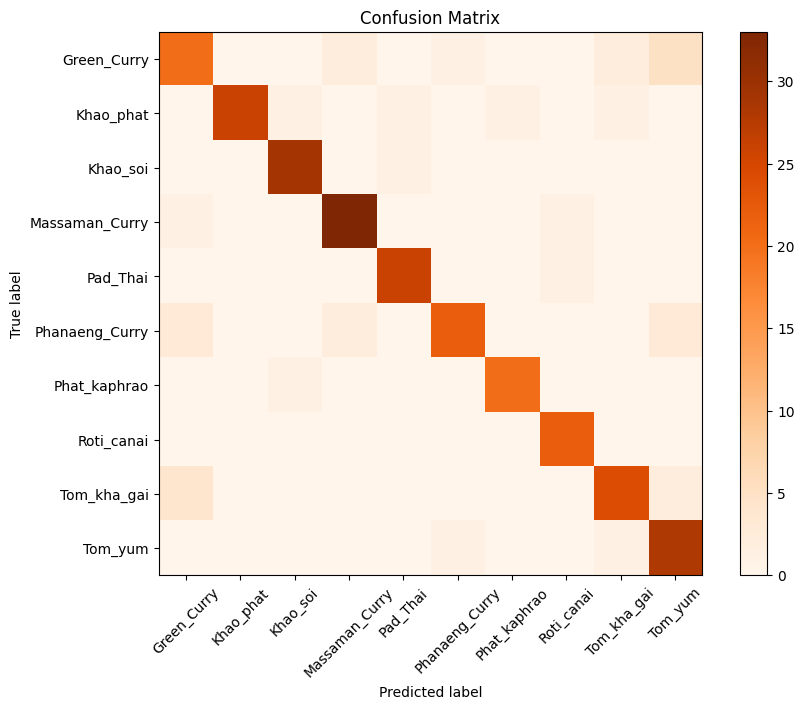

In [138]:
##### Evaluate the testing #####
score = model_ResNet152V2.evaluate(test_generator, verbose=False) ### !!!
print('Test loss:', score[0])
print('Test accuracy:', score[1])

true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model_ResNet152V2.predict(x_batch) ### !!!
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [139]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

                precision    recall  f1-score   support

   Green_Curry       0.71      0.67      0.69        30
     Khao_phat       1.00      0.87      0.93        30
      Khao_soi       0.94      0.97      0.95        30
Massaman_Curry       0.89      0.94      0.92        35
      Pad_Thai       0.93      0.96      0.95        27
Phanaeng_Curry       0.92      0.73      0.81        30
  Phat_kaphrao       0.95      0.95      0.95        21
    Roti_canai       0.92      1.00      0.96        22
   Tom_kha_gai       0.86      0.80      0.83        30
       Tom_yum       0.74      0.93      0.82        30

      accuracy                           0.88       285
     macro avg       0.88      0.88      0.88       285
  weighted avg       0.88      0.88      0.88       285



In [140]:
model_ResNet152V2.save('04_model_ResNet152V2_RUN_1.keras')

### 5) VGG19

In [141]:
##### Get the weights #####
base_model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3)) ### !!!

##### Freeze the layers of the base model #####
for layer in base_model_VGG19.layers: ### !!!
    layer.trainable = False
    
##### Build the model #####
model_VGG19 = tf.keras.models.Sequential([ ### !!!
    base_model_VGG19, ### !!!
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_VGG19.summary()

##### Set the optimizer #####
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model_VGG19.compile(optimizer=optimizer, ##### !!!
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_21  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_228 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 10)              

In [142]:
##### Training model #####

history = model_VGG19.fit( ### !!!
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[callback]
)

Epoch 1/100
123/123 [==============================] - 31s 235ms/step - loss: 1.8787 - accuracy: 0.4656 - val_loss: 1.3623 - val_accuracy: 0.5446 - lr: 0.0092
Epoch 2/100
123/123 [==============================] - 29s 239ms/step - loss: 1.3710 - accuracy: 0.5900 - val_loss: 0.9996 - val_accuracy: 0.6321 - lr: 0.0084
Epoch 3/100
123/123 [==============================] - 29s 235ms/step - loss: 1.2337 - accuracy: 0.6405 - val_loss: 0.8668 - val_accuracy: 0.6964 - lr: 0.0077
Epoch 4/100
123/123 [==============================] - 29s 236ms/step - loss: 1.1340 - accuracy: 0.6747 - val_loss: 1.0492 - val_accuracy: 0.6375 - lr: 0.0071
Epoch 5/100
123/123 [==============================] - 29s 235ms/step - loss: 1.0551 - accuracy: 0.6905 - val_loss: 0.7989 - val_accuracy: 0.7232 - lr: 0.0065
Epoch 6/100
123/123 [==============================] - 29s 234ms/step - loss: 0.9690 - accuracy: 0.7185 - val_loss: 1.0171 - val_accuracy: 0.6589 - lr: 0.0060
Epoch 7/100
123/123 [=========================

In [143]:
##### Plot ACC #####

h1_ACC = go.Scatter(y=history.history['accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="acc"
                   )
h2_ACC = go.Scatter(y=history.history['val_accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_acc"
                   )

data_ACC = [h1_ACC ,h2_ACC]
layout_ACC = go.Layout(title='Accuracy',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_ACC = go.Figure(data = data_ACC, layout=layout_ACC)
plotly.offline.iplot(fig_ACC)


##### Plot Loss #####

h1_Loss = go.Scatter(y=history.history['loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="loss"
                   )
h2_Loss = go.Scatter(y=history.history['val_loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_loss"
                   )

data_Loss = [h1_Loss,h2_Loss]
layout_Loss = go.Layout(title='Loss',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig_Loss = go.Figure(data = data_Loss, layout=layout_Loss)
plotly.offline.iplot(fig_Loss)

Test loss: 0.6403616070747375
Test accuracy: 0.7859649062156677
1/1 [==============================] - 0s 24ms/step


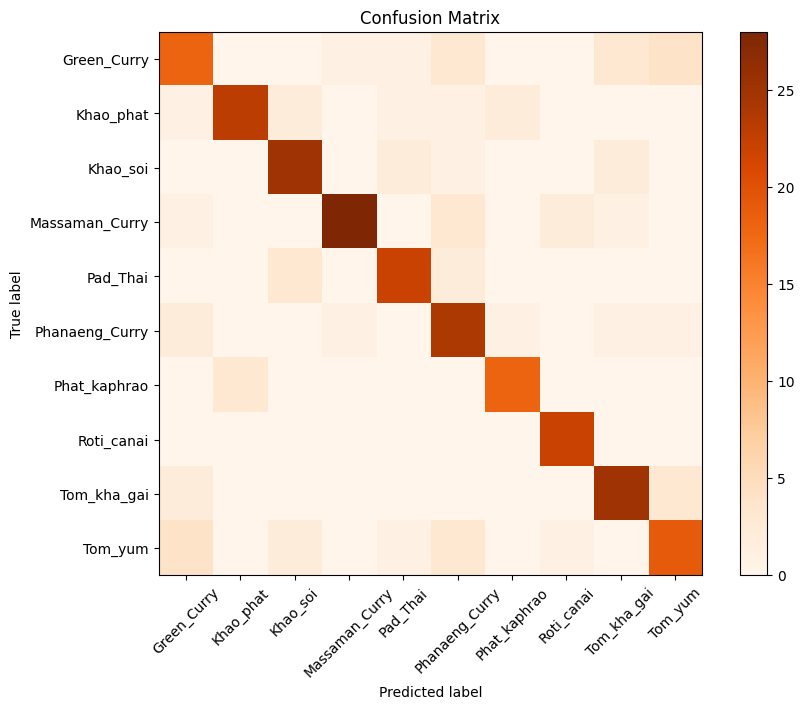

In [144]:
##### Evaluate the testing #####
score = model_VGG19.evaluate(test_generator, verbose=False) ### !!!
print('Test loss:', score[0])
print('Test accuracy:', score[1])

true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model_VGG19.predict(x_batch) ### !!!
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [145]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

                precision    recall  f1-score   support

   Green_Curry       0.64      0.60      0.62        30
     Khao_phat       0.88      0.77      0.82        30
      Khao_soi       0.78      0.83      0.81        30
Massaman_Curry       0.93      0.80      0.86        35
      Pad_Thai       0.81      0.81      0.81        27
Phanaeng_Curry       0.65      0.80      0.72        30
  Phat_kaphrao       0.86      0.86      0.86        21
    Roti_canai       0.88      1.00      0.94        22
   Tom_kha_gai       0.78      0.83      0.81        30
       Tom_yum       0.70      0.63      0.67        30

      accuracy                           0.79       285
     macro avg       0.79      0.79      0.79       285
  weighted avg       0.79      0.79      0.79       285



In [146]:
model_VGG19.save('05_model_VGG19_RUN_1.keras')